#  Unsupervised learning addition model with generator

Author: S. Menary [sbmenary@gmail.com]

Date: 11/4/2023  (last update: 28/6/2023)

Overview: Train a `sequence -> sequence` model where the input sequence is a text representation of a simple sum $\sum_{i=1}^N A_i$ for a configurable number $N$ of integers $A_i\in\mathbb{Z}$, and the output is a set of logits representing the probability of each token in the output sequence. Integers may have a configurable number of digits. At inference time, chains of text are generated auto-regressively until the terminate-sequence token is reached. The loss function is a sparse categorical entropy.

The transformer is configurable. We support
- learnable skip connections
- learnable positional encodings
- multiple encoded outputs given equal weight in the loss function (to encourage convergence)
- repetition of encoder/decoder blocks in loops
- pre-loop layers allowing the transformer to process the input into an initial representation

---

## 1. Set up program

###  Import

All imports go here at the top of the notebook

In [1]:
##=========================##
##   All imports go here   ##
##=========================##

##  Import entire python stdlib packages
import logging, os, sys

##  Import entire pypi packages
import tensorflow as tf

##  Remove tensorflow INFO messages
tf.get_logger().setLevel('WARNING')

##  Add directory above this to system path to expose mathsformer package location
sys.path.append("/".join(os.getcwd().split("/")[:-1]))

##  Import individual modules/objects from local packages
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.optimizers import AdamW
from mathsformer import config, data, transformers, utils
from mathsformer import selfsupervised_learning_addition_model_backend as backend


## 1. Configure run

Set configuration variables for entire program

In [2]:
##==============================##
##   Set custom config values   ##
##==============================##

custom_config = {
    "global" : {
        "base_seed"        : 100,
        "working_dir"      : "SSL_loopy_enc_dec_notebook_int[data>train_data>int_lengths]_num[data>train_data>num_ints]_embed[model>ndim_embedding]_enc_[model>encoder>num_blocks]blocks_[model>encoder>num_loops]loops_width[model>encoder>ndim_ff_hidden]_dec_[model>decoder>num_blocks]blocks_[model>decoder>num_loops]loops_width[model>decoder>ndim_ff_hidden]_post[model>post_decoder>num_layers]_width[model>post_decoder>ndim]_idem[model>idempotent_size]_[date]",
        "log_lvl_iostream" : logging.INFO,
        "log_lvl_fstream"  : logging.DEBUG,
    },
    "data" : {
        "train_data" : {
            "int_lengths"      : [1, 2, 3, 4],
            "num_ints"         : [1, 2, 4, 5],
            "batch_size"       : 32,
            "num_batches"      : 2000,
            "gen_base_seed"    : 101,
            "gen_reproducible" : False, 
        },
        "val_data" : {
            "int_lengths"      : [1, 2, 3, 4],
            "num_ints"         : [3],
            "batch_size"       : 32,
            "num_batches"      : 50,
            "gen_base_seed"    : 102,
            "gen_reproducible" : True,
        },
        "test_data" : {
            "int_lengths"      : [1, 2, 3, 4],
            "num_ints"         : [6, 7],
            "batch_size"       : 32,
            "num_batches"      : 100,
            "gen_base_seed"    : 103,
            "gen_reproducible" : True,
        },
        "characters"              : ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-'],
        "mask_char"               : 'M',
        "seq_start_char"          : 'B',
        "seq_end_char"            : 'E',
        "negative_char"           : 'N',
        "dtype"                   : "int32",
    },
    "model" : {
        "load_model" : {
            "do"    : False,
            "fname" : None,
        },
        "update_model" : {
            "do"     : False,
            "kwargs" : {}, #{"num_encoder_loops": 18},
        },
        "create_model" : {
            "name"                  : "mathsformer_LLM",
            "dtype"                 : "float32",
            "dropout"               : 0.1,
            "jit_compile"           : False,
            "use_old_loss"          : True,
            "optimizer"             : AdamW,
            "optimizer_args"        : {"learning_rate":1e-4, "weight_decay":1e-2},
            "idempotent_size"       : 2,
            "positional_encoding" : {
                "num_freqs"         : 64,
                "min_period"        : 4,
                "max_period"        : 1600,
                "learnable"         : False,
                "do_decoder"        : True,
            },
            "ndim_embedding"        : 128,
            "comb_type"             : 'mixture',
            "pre_encoder" : {
                "num_blocks"           : 2,
                "num_loops"            : 1,
                "num_heads"            : 8,
                "ndim"                 : 128,
                "ndim_att_hidden"      : 128,
                "ndim_ff_hidden"       : 512,
                "skip_connect"         : True,
                "mixture_skip_connect" : True,
            },
            "encoder" : {
                "num_blocks"           : 2,
                "num_loops"            : 4,
                "num_heads"            : 8,
                "ndim"                 : 128,
                "ndim_att_hidden"      : 128,
                "ndim_ff_hidden"       : 512,
                "skip_connect"         : True,
                "mixture_skip_connect" : False,
            },
            "decoder" : {
                "num_blocks"           : 2,
                "num_loops"            : 1,
                "num_heads"            : 8,
                "ndim"                 : 128,
                "ndim_att_hidden"      : 128,
                "ndim_ff_hidden"       : 512,
                "skip_connect"         : True,
                "mixture_skip_connect" : False,
            },
            "post_decoder" : {
                "num_layers"        : 3,
                "ndim"              : 512,
            },
        },
    },
    "training" : {
        "train"          : True,
        "max_epochs"     : 100000,
        "early_stopping" : {
            "do"                   : False,
            "patience"             : 6,
            "monitor"              : "loss",
            "mode"                 : "min",
            "restore_best_weights" : True,
        },
        "adaptive_learning_rate" : {
            "do"           : True,
            "decay_factor" : 0.25,
            "monitor"      : "loss",
            "mode"         : "min",
            "patience"     : 1,
            "log_lvl"      : logging.DEBUG,
        },
        "stop_by_metric" : {
            "do"         : True,
            "metric"     : "mathsformer_LLM_output_masked_categorical_accuracy",
            "stop_value" : 0.999,
            "mode"       : "max",
        },
        "model_checkpoint" : {
            "do"       : True,
            "filename" : "model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.keras",
        },
        "log_after_epoch" : {
            "do"          : True,
            "log_lvl"     : logging.DEBUG,
        },
        "layer_weights_record" : {
            "do"               : False,
            "batch_frequency"  : 2000,
            "recursive"        : True,
        },
        "print_tables_during_training" : {
            "do"        : True,
            "num_print" : 15,
        },
    },
    "evaluate" : {
        "num_print"            : 50,
        "save_model"           : True,
        "plot_weights"         : False,
        "plot_training_curves" : True,
    },
}


In [3]:
##===================================##
##   Load and validate full config   ##
##===================================##

##  Create config object containing default values
cfg = config.Config(backend.DEFAULT_CONFIG)

##  Override with custom values
cfg.load_dict(custom_config)

##  Validate config
backend.validate_config(cfg)

##  Print success
print(utils.fancy_message(f"Config created"))

##  For convenience, split configs for different sections
cfg_global     = cfg["global"  ]
cfg_data       = cfg["data"    ]
cfg_model      = cfg["model"   ]
cfg_training   = cfg["training"]
cfg_evaluate   = cfg["evaluate"]


===   Config created   ===


##  2. Set up environment

- Create working directory
- Create logger
- Log package versions for reproducibility
- Log config values for reproducibility
- Set random seeds for reproducibility


In [4]:
##==============================##
##   Create working directory   ##
##==============================##

##  Report success
working_dir, logger, base_seed, np_seed, tf_seed = utils.initialise_program(
    "unsupervised_learning_addition_model_generator (notebook)", 
    working_dir       = cfg_global["working_dir"], 
    cfg               = cfg,
    base_seed         = cfg_global["base_seed"],
    log_lvl_iostream  = cfg_global["log_lvl_iostream"],
    log_lvl_fstream   = cfg_global["log_lvl_fstream" ],
)


===   Working directory created at SSL_loopy_enc_dec_notebook_int1234_num1245_embed128_enc_2blocks_4loops_width512_dec_3blocks_1loops_width512_post3_width512_idem2_2023_07_02_v4   ===
   INFO initialise_logging: Begin logging on 2023-07-02 at 22:37:51
   INFO initialise_program: Program description: unsupervised_learning_addition_model_generator (notebook)
   INFO initialise_program: Working directory: SSL_loopy_enc_dec_notebook_int1234_num1245_embed128_enc_2blocks_4loops_width512_dec_3blocks_1loops_width512_post3_width512_idem2_2023_07_02_v4
   INFO log_versions: ------------------------------------------------------+------------------------------------------------------
   INFO log_versions:                                              PACKAGE  |  VERSION
   INFO log_versions: ------------------------------------------------------+------------------------------------------------------
   INFO log_versions:                                               Python  |  3.11.3 (main, May 15 

   INFO log_versions:                                       prompt_toolkit  |  3.0.38
   INFO log_versions:                                               psutil  |  5.9.5
   INFO log_versions:                                           ptyprocess  |  0.7.0
   INFO log_versions:                                            pure_eval  |  0.2.2
   INFO log_versions:                                    pure_eval.version  |  0.2.2
   INFO log_versions:                                               pydevd  |  2.9.5
   INFO log_versions:                                             pygments  |  2.15.1
   INFO log_versions:                                            pyparsing  |  3.1.0
   INFO log_versions:                                                   re  |  2.2.1
   INFO log_versions:                                             requests  |  2.31.0
   INFO log_versions:                                 requests.__version__  |  2.31.0
   INFO log_versions:                                        

   INFO initialise_program: Registered config value data > val_data > batch_size: 32
   INFO initialise_program: Registered config value data > val_data > num_batches: 50
   INFO initialise_program: Registered config value data > val_data > gen_base_seed: 102
   INFO initialise_program: Registered config value data > val_data > gen_reproducible: True
   INFO initialise_program: Registered config value data > test_data > int_lengths: [1, 2, 3, 4]
   INFO initialise_program: Registered config value data > test_data > num_ints: [6, 7]
   INFO initialise_program: Registered config value data > test_data > batch_size: 32
   INFO initialise_program: Registered config value data > test_data > num_batches: 100
   INFO initialise_program: Registered config value data > test_data > gen_base_seed: 103
   INFO initialise_program: Registered config value data > test_data > gen_reproducible: True
   INFO initialise_program: Registered config value data > characters: ['M', 'B', 'E', 'N', '0', '1', '2

   INFO initialise_program: Registered config value model > create_model > encoder > ndim_att_hidden: 128
   INFO initialise_program: Registered config value model > create_model > encoder > ndim_ff_hidden: 512
   INFO initialise_program: Registered config value model > create_model > encoder > skip_connect: True
   INFO initialise_program: Registered config value model > create_model > encoder > mixture_skip_connect: False
   INFO initialise_program: Registered config value model > create_model > decoder > num_blocks: 2
   INFO initialise_program: Registered config value model > create_model > decoder > num_loops: 1
   INFO initialise_program: Registered config value model > create_model > decoder > num_heads: 8
   INFO initialise_program: Registered config value model > create_model > decoder > ndim: 128
   INFO initialise_program: Registered config value model > create_model > decoder > ndim_att_hidden: 128
   INFO initialise_program: Registered config value model > create_model > d

###  Report tensorflow devices


In [5]:
##  Log tensorflow devices found
logger.info(f"Tensorflow with the following physical devices: {tf.config.list_physical_devices()}")

   INFO <module>: Tensorflow with the following physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


##  3. Create training data

###  Create tokeniser

Tokeniser object handles the transformation from strings to tensors and back again

In [6]:
##======================##
##   Create tokeniser   ##
##======================##

token_transform = data.TokenTransform.from_dictionary(cfg_data)
token_transform.summary(print_fn=logger.info)


   INFO summary: TokenTransform of dtype int32 with 16 characters: ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-']
   INFO summary: Special characters are seq_start_char (B), seq_end_char (E), mask_char (M)
   INFO summary: Tokeniser dictionary is {'M': 0, 'B': 1, 'E': 2, 'N': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '+': 14, '-': 15}
   INFO summary: Detokeniser dictionary is {0: 'M', 1: 'B', 2: 'E', 3: 'N', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '+', 15: '-'}


###  Create data generators for train/val/test sets

Data generators create tensor inputs/outputs for the model on-the-fly


In [7]:
##============================##
##   Create data generators   ##
##============================##

negative_char = cfg_data.get("negative_char")
train_gen, train_gen_reproducible, val_gen, test_gen = backend.get_data_generators(cfg_data, token_transform)


   INFO get_data_generators: Training data generator created with the following config: Generator of [1, 2, 4, 5] integers of length [1, 2, 3, 4] in 2000 batches of size 32 (base_seed=101, reproducible=False)
   INFO get_data_generators: Output shapes for a test batch are ((32, 27), (32, 6)), (32, 6)
   INFO get_data_generators: Validation data generator created with the following config: Generator of [3] integers of length [1, 2, 3, 4] in 50 batches of size 32 (base_seed=102, reproducible=True)
   INFO get_data_generators: Output shapes for a test batch are ((32, 18), (32, 6)), (32, 6)
   INFO get_data_generators: Test data generator created with the following config: Generator of [6, 7] integers of length [1, 2, 3, 4] in 100 batches of size 32 (base_seed=103, reproducible=True)
   INFO get_data_generators: Output shapes for a test batch are ((32, 36), (32, 7)), (32, 7)


###  Visualise training data

Plot the distribution of tokens in the training data, which helps us interpret the per-token accuracy in early training

   INFO plot_token_distribution: Saving distribution of token frequencies to file SSL_loopy_enc_dec_notebook_int1234_num1245_embed128_enc_2blocks_4loops_width512_dec_3blocks_1loops_width512_post3_width512_idem2_2023_07_02_v4/token_distribution.pdf


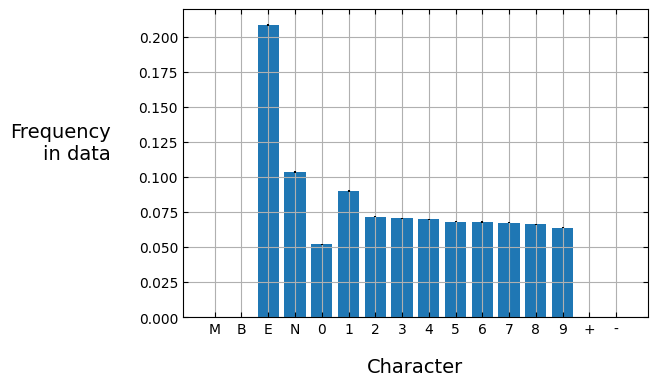

In [8]:
##=========================================================##
##   Quickly visualise distribution of token frequencies   ##
##=========================================================##

backend.plot_token_distribution(train_gen, savefig=f"{working_dir}/token_distribution.pdf")


##  4.  Create model

Create the keras model object that handles sequence-sequence transformations from alread-tokenised data

In [9]:
##==========================##
##   Create or load model   ##
##==========================##
  
##  Load model if configured, otherwise create one
##
if cfg_model["load_model"].get("do", False) :
            
    ##  Load model from file         
    fname = cfg_model["load_model"]["fname"]
    logger.info   (f"Loading model from: {fname}")
    logger.warning("Loading a pretrained model will disregard model config!")          
    model = backend.load_text_to_text_model(fname)
    
    ##  Assign new learning rate to model
    learning_rate = cfg_model["create_model"]["optimizer_args"]["learning_rate"]
    logger.info(f"Setting learning rate to: {learning_rate}")
    logger.warning("Not updating other optimizer settings - can't confirm they are compatible!")     
    model.optimizer.learning_rate.assign(learning_rate)
    
else :
    
    ##  Create new model
    logger.info(f"Creating new text-to-text model")
    model = backend.create_text_to_text_model_from_config(cfg_model["create_model"], token_transform)
       

   INFO <module>: Creating new text-to-text model


In [10]:
##==================##
##   Modify model   ##
##==================##

##  Modify model if configured
##
if cfg_model["update_model"].get("do", False) :
    kwargs = cfg_model["update_model"]["kwargs"]
    logger.info(f"Updating model with kwargs: {kwargs}")
    model  = backend.create_derived_model(model, cfg_model["create_model"], token_transform, **kwargs)
    

In [11]:
##===============##
##   Log model   ##
##===============##

##  Create hack to catch model summary
model_summary = []
model.summary(print_fn = lambda s : model_summary.append(s))

##  Print model summary
logger.info("Model created with summary:")
for s in model_summary : logger.info(s)
    
##  Print optimizer summary
logger.info(f"Optimizer is {model.optimizer}")
if hasattr(model.optimizer, "learning_rate") : logger.info(f"Learning rate is {model.optimizer.learning_rate}")
if hasattr(model.optimizer, "weight_decay" ) : logger.info(f"Weight decay is {model.optimizer.weight_decay}")


   INFO <module>: Model created with summary:


INFO:mathsformer:Model created with summary:


   INFO <module>: Model: "mathsformer_LLM"


INFO:mathsformer:Model: "mathsformer_LLM"


   INFO <module>: __________________________________________________________________________________________________


INFO:mathsformer:__________________________________________________________________________________________________


   INFO <module>:  Layer (type)                   Output Shape         Param #     Connected to                     


INFO:mathsformer: Layer (type)                   Output Shape         Param #     Connected to                     


   INFO <module>: ==================================================================================================


INFO:mathsformer:==================================================================================================


   INFO <module>:  mathsformer_LLM_encoder_input_  [(None, None)]      0           []                               


INFO:mathsformer: mathsformer_LLM_encoder_input_  [(None, None)]      0           []                               


   INFO <module>:  layer (InputLayer)                                                                               


INFO:mathsformer: layer (InputLayer)                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_enumer  (None, None)        0           ['mathsformer_LLM_encoder_input_l


INFO:mathsformer: mathsformer_LLM_encoder_enumer  (None, None)        0           ['mathsformer_LLM_encoder_input_l


   INFO <module>:  ate (Enumerate)                                                 ayer[0][0]']                     


INFO:mathsformer: ate (Enumerate)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_embedd  (None, None, 128)   2048        ['mathsformer_LLM_encoder_input_l


INFO:mathsformer: mathsformer_LLM_encoder_embedd  (None, None, 128)   2048        ['mathsformer_LLM_encoder_input_l


   INFO <module>:  ing (Embedding)                                                 ayer[0][0]']                     


INFO:mathsformer: ing (Embedding)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_positi  (None, None, 128)   64          ['mathsformer_LLM_encoder_enumera


INFO:mathsformer: mathsformer_LLM_encoder_positi  (None, None, 128)   64          ['mathsformer_LLM_encoder_enumera


   INFO <module>:  on_encoding (PositionalEncodin                                  te[0][0]']                       


INFO:mathsformer: on_encoding (PositionalEncodin                                  te[0][0]']                       


   INFO <module>:  g)                                                                                               


INFO:mathsformer: g)                                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_emb_an  (None, None, 128)   0           ['mathsformer_LLM_encoder_embeddi


INFO:mathsformer: mathsformer_LLM_encoder_emb_an  (None, None, 128)   0           ['mathsformer_LLM_encoder_embeddi


   INFO <module>:  d_pos (Average)                                                 ng[0][0]',                       


INFO:mathsformer: d_pos (Average)                                                 ng[0][0]',                       


   INFO <module>:                                                                   'mathsformer_LLM_encoder_positio


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_positio


   INFO <module>:                                                                  n_encoding[0][0]']               


INFO:mathsformer:                                                                 n_encoding[0][0]']               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_preencoder_blo  (None, None, 128)   659716      ['mathsformer_LLM_encoder_emb_and


INFO:mathsformer: mathsformer_LLM_preencoder_blo  (None, None, 128)   659716      ['mathsformer_LLM_encoder_emb_and


   INFO <module>:  ck_1 (EncoderBlock)                                             _pos[0][0]']                     


INFO:mathsformer: ck_1 (EncoderBlock)                                             _pos[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_preencoder_blo  (None, None, 128)   659716      ['mathsformer_LLM_preencoder_bloc


INFO:mathsformer: mathsformer_LLM_preencoder_blo  (None, None, 128)   659716      ['mathsformer_LLM_preencoder_bloc


   INFO <module>:  ck_2 (EncoderBlock)                                             k_1[0][0]']                      


INFO:mathsformer: ck_2 (EncoderBlock)                                             k_1[0][0]']                      


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_block_  (None, None, 128)   659712      ['mathsformer_LLM_preencoder_bloc


INFO:mathsformer: mathsformer_LLM_encoder_block_  (None, None, 128)   659712      ['mathsformer_LLM_preencoder_bloc


   INFO <module>:  1 (EncoderBlock)                                                k_2[0][0]',                      


INFO:mathsformer: 1 (EncoderBlock)                                                k_2[0][0]',                      


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [0][0]',                         


INFO:mathsformer:                                                                 [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [2][0]',                         


INFO:mathsformer:                                                                 [2][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [3][0]',                         


INFO:mathsformer:                                                                 [3][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [4][0]']                         


INFO:mathsformer:                                                                 [4][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_block_  (None, None, 128)   659712      ['mathsformer_LLM_encoder_block_1


INFO:mathsformer: mathsformer_LLM_encoder_block_  (None, None, 128)   659712      ['mathsformer_LLM_encoder_block_1


   INFO <module>:  2 (EncoderBlock)                                                [0][0]',                         


INFO:mathsformer: 2 (EncoderBlock)                                                [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [2][0]',                         


INFO:mathsformer:                                                                 [2][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [3][0]',                         


INFO:mathsformer:                                                                 [3][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [4][0]',                         


INFO:mathsformer:                                                                 [4][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [5][0]']                         


INFO:mathsformer:                                                                 [5][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_input_  [(None, None)]      0           []                               


INFO:mathsformer: mathsformer_LLM_decoder_input_  [(None, None)]      0           []                               


   INFO <module>:  layer (InputLayer)                                                                               


INFO:mathsformer: layer (InputLayer)                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_enumer  (None, None)        0           ['mathsformer_LLM_decoder_input_l


INFO:mathsformer: mathsformer_LLM_decoder_enumer  (None, None)        0           ['mathsformer_LLM_decoder_input_l


   INFO <module>:  ate (Enumerate)                                                 ayer[0][0]']                     


INFO:mathsformer: ate (Enumerate)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_embedd  (None, None, 128)   2048        ['mathsformer_LLM_decoder_input_l


INFO:mathsformer: mathsformer_LLM_decoder_embedd  (None, None, 128)   2048        ['mathsformer_LLM_decoder_input_l


   INFO <module>:  ing (Embedding)                                                 ayer[0][0]']                     


INFO:mathsformer: ing (Embedding)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_positi  (None, None, 128)   64          ['mathsformer_LLM_decoder_enumera


INFO:mathsformer: mathsformer_LLM_decoder_positi  (None, None, 128)   64          ['mathsformer_LLM_decoder_enumera


   INFO <module>:  on_encoding (PositionalEncodin                                  te[0][0]']                       


INFO:mathsformer: on_encoding (PositionalEncodin                                  te[0][0]']                       


   INFO <module>:  g)                                                                                               


INFO:mathsformer: g)                                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_emb_an  (None, None, 128)   0           ['mathsformer_LLM_decoder_embeddi


INFO:mathsformer: mathsformer_LLM_decoder_emb_an  (None, None, 128)   0           ['mathsformer_LLM_decoder_embeddi


   INFO <module>:  d_pos (Average)                                                 ng[0][0]',                       


INFO:mathsformer: d_pos (Average)                                                 ng[0][0]',                       


   INFO <module>:                                                                   'mathsformer_LLM_decoder_positio


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_positio


   INFO <module>:                                                                  n_encoding[0][0]']               


INFO:mathsformer:                                                                 n_encoding[0][0]']               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_block_  (None, None, 128)   1187456     ['mathsformer_LLM_decoder_emb_and


INFO:mathsformer: mathsformer_LLM_decoder_block_  (None, None, 128)   1187456     ['mathsformer_LLM_decoder_emb_and


   INFO <module>:  1 (DecoderBlock)                                                _pos[0][0]',                     


INFO:mathsformer: 1 (DecoderBlock)                                                _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [3][0]',                         


INFO:mathsformer:                                                                 [3][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_emb_and


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_emb_and


   INFO <module>:                                                                  _pos[0][0]',                     


INFO:mathsformer:                                                                 _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [4][0]',                         


INFO:mathsformer:                                                                 [4][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_emb_and


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_emb_and


   INFO <module>:                                                                  _pos[0][0]',                     


INFO:mathsformer:                                                                 _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [5][0]']                         


INFO:mathsformer:                                                                 [5][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_block_  (None, None, 128)   1187456     ['mathsformer_LLM_decoder_block_1


INFO:mathsformer: mathsformer_LLM_decoder_block_  (None, None, 128)   1187456     ['mathsformer_LLM_decoder_block_1


   INFO <module>:  2 (DecoderBlock)                                                [0][0]',                         


INFO:mathsformer: 2 (DecoderBlock)                                                [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [3][0]',                         


INFO:mathsformer:                                                                 [3][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_1


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [4][0]',                         


INFO:mathsformer:                                                                 [4][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_1


   INFO <module>:                                                                  [2][0]',                         


INFO:mathsformer:                                                                 [2][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [5][0]']                         


INFO:mathsformer:                                                                 [5][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_output (FeedFo  (None, None, 16)    599824      ['mathsformer_LLM_decoder_block_2


INFO:mathsformer: mathsformer_LLM_output (FeedFo  (None, None, 16)    599824      ['mathsformer_LLM_decoder_block_2


   INFO <module>:  rwardBlock)                                                     [0][0]',                         


INFO:mathsformer: rwardBlock)                                                     [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_2


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_2


   INFO <module>:                                                                  [2][0]']                         


INFO:mathsformer:                                                                 [2][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>: ==================================================================================================


INFO:mathsformer:==================================================================================================


   INFO <module>: Total params: 5,617,816


INFO:mathsformer:Total params: 5,617,816


   INFO <module>: Trainable params: 5,617,816


INFO:mathsformer:Trainable params: 5,617,816


   INFO <module>: Non-trainable params: 0


INFO:mathsformer:Non-trainable params: 0


   INFO <module>: __________________________________________________________________________________________________


INFO:mathsformer:__________________________________________________________________________________________________


   INFO <module>: Optimizer is <keras.optimizers.adamw.AdamW object at 0x289e46f50>


INFO:mathsformer:Optimizer is <keras.optimizers.adamw.AdamW object at 0x289e46f50>


   INFO <module>: Learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


INFO:mathsformer:Learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


   INFO <module>: Weight decay is 0.01


INFO:mathsformer:Weight decay is 0.01


In [12]:
##==============================================================##
##   Create transformer wrapper for model and token_transform   ##
##==============================================================##

transformer = transformers.Transformer_Text_to_Text(model, token_transform)


In [13]:
##========================##
##   Save initial model   ##
##========================##

save_fname = f"{working_dir}/initial_model.keras"
model.save(save_fname)


In [14]:
##================================== ====##
##   Print initial model metric values   ##
##================================== ====##

backend.log_metrics(
               model, 
               [train_gen_reproducible, val_gen, test_gen], 
               ["training", "validation", "test"],
               verbose=1,
              )


2023-07-02 22:37:56.744959: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


50/50 [==============================] - 11s 187ms/step - loss: 8.4301 - mathsformer_LLM_output_loss: 2.8046 - mathsformer_LLM_output_1_loss: 2.8114 - mathsformer_LLM_output_2_loss: 2.8141 - mathsformer_LLM_output_masked_categorical_accuracy: 0.0351 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.0338 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.0252
   INFO log_metrics: Model with training metrics:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Model with training metrics:


   INFO log_metrics:     loss:  8.430139541625977


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    loss:  8.430139541625977


   INFO log_metrics:     mathsformer_LLM_output_loss:  2.8045876026153564


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_loss:  2.8045876026153564


   INFO log_metrics:     mathsformer_LLM_output_1_loss:  2.811411142349243


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_1_loss:  2.811411142349243


   INFO log_metrics:     mathsformer_LLM_output_2_loss:  2.8141417503356934


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_2_loss:  2.8141417503356934


   INFO log_metrics:     mathsformer_LLM_output_masked_categorical_accuracy:  0.03506392240524292


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_masked_categorical_accuracy:  0.03506392240524292


   INFO log_metrics:     mathsformer_LLM_output_1_masked_categorical_accuracy:  0.03376105800271034


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_1_masked_categorical_accuracy:  0.03376105800271034


   INFO log_metrics:     mathsformer_LLM_output_2_masked_categorical_accuracy:  0.025232672691345215


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_2_masked_categorical_accuracy:  0.025232672691345215


50/50 [==============================] - 8s 162ms/step - loss: 8.4229 - mathsformer_LLM_output_loss: 2.8032 - mathsformer_LLM_output_1_loss: 2.8089 - mathsformer_LLM_output_2_loss: 2.8108 - mathsformer_LLM_output_masked_categorical_accuracy: 0.0312 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.0295 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.0205
   INFO log_metrics: Model with validation metrics:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Model with validation metrics:


   INFO log_metrics:     loss:  8.422905921936035


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    loss:  8.422905921936035


   INFO log_metrics:     mathsformer_LLM_output_loss:  2.8032407760620117


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_loss:  2.8032407760620117


   INFO log_metrics:     mathsformer_LLM_output_1_loss:  2.8088793754577637


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_1_loss:  2.8088793754577637


   INFO log_metrics:     mathsformer_LLM_output_2_loss:  2.8107874393463135


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_2_loss:  2.8107874393463135


   INFO log_metrics:     mathsformer_LLM_output_masked_categorical_accuracy:  0.03123398683965206


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_masked_categorical_accuracy:  0.03123398683965206


   INFO log_metrics:     mathsformer_LLM_output_1_masked_categorical_accuracy:  0.029510481283068657


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_1_masked_categorical_accuracy:  0.029510481283068657


   INFO log_metrics:     mathsformer_LLM_output_2_masked_categorical_accuracy:  0.020522590726614


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_2_masked_categorical_accuracy:  0.020522590726614


100/100 [==============================] - 32s 315ms/step - loss: 8.3923 - mathsformer_LLM_output_loss: 2.7926 - mathsformer_LLM_output_1_loss: 2.7987 - mathsformer_LLM_output_2_loss: 2.8010 - mathsformer_LLM_output_masked_categorical_accuracy: 0.0364 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.0343 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.0257
   INFO log_metrics: Model with test metrics:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Model with test metrics:


   INFO log_metrics:     loss:  8.39232063293457


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    loss:  8.39232063293457


   INFO log_metrics:     mathsformer_LLM_output_loss:  2.7926018238067627


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_loss:  2.7926018238067627


   INFO log_metrics:     mathsformer_LLM_output_1_loss:  2.7986860275268555


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_1_loss:  2.7986860275268555


   INFO log_metrics:     mathsformer_LLM_output_2_loss:  2.8010337352752686


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_2_loss:  2.8010337352752686


   INFO log_metrics:     mathsformer_LLM_output_masked_categorical_accuracy:  0.036386795341968536


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_masked_categorical_accuracy:  0.036386795341968536


   INFO log_metrics:     mathsformer_LLM_output_1_masked_categorical_accuracy:  0.03434767574071884


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_1_masked_categorical_accuracy:  0.03434767574071884


   INFO log_metrics:     mathsformer_LLM_output_2_masked_categorical_accuracy:  0.025705033913254738


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    mathsformer_LLM_output_2_masked_categorical_accuracy:  0.025705033913254738


In [15]:
##=========================================##
##   Test transformer on data generators   ##
##=========================================##

backend.test_transformer(transformer, train_gen, val_gen, test_gen, negative_char=train_gen.negative_char)


   INFO test_transformer: Running text --> text mathsformer inference on some training data:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:


   INFO print_predictions_table: ------------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:------------------------------------------------------------------------------------------


   INFO print_predictions_table:                   INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                  INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


   INFO print_predictions_table: ------------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:------------------------------------------------------------------------------------------


   INFO print_predictions_table:                     N81          N81        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                    N81          N81        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:      37+4457-N353+N2+N7         4838        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:     37+4457-N353+N2+N7         4838        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:                     N52          N52        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                    N52          N52        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:                621-2490        N1869        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:               621-2490        N1869        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:  4906+N262-48+483-N5139        10218        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: 4906+N262-48+483-N5139        10218        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:                  536-59          477        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                 536-59          477        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:              3+N5-54+N4          N60        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:             3+N5-54+N4          N60        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:              N782-N4910         4128        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:             N782-N4910         4128        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:     89+N44-59-N939+N870           55        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    89+N44-59-N939+N870           55        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:           9782+419-N4+2        10207        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:          9782+419-N4+2        10207        B55MM BB55MMMB11116B                      ?   


   INFO test_transformer: Running text --> text mathsformer inference on some validation data:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some validation data:


   INFO print_predictions_table: ---------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------


   INFO print_predictions_table:          INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


INFO:mathsformer.selfsupervised_learning_addition_model_backend:         INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


   INFO print_predictions_table: ---------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:---------------------------------------------------------------------------------


   INFO print_predictions_table:   3-N3988+N847         3144        B555M BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  3-N3988+N847         3144        B555M BB55MMMB11116B                      ?   


   INFO print_predictions_table:      7797+5-N4         7806        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:     7797+5-N4         7806        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:   N8357-N11+N7        N8353        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  N8357-N11+N7        N8353        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:  6686-N437-236         6887        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: 6686-N437-236         6887        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:      N5+4442+8         4445        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:     N5+4442+8         4445        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:    2123-N1+N68         2056        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:   2123-N1+N68         2056        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:    95+4563+879         5537        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:   95+4563+879         5537        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:   1639+N2868+5        N1224        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  1639+N2868+5        N1224        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:       8+N725-3         N720        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:      8+N725-3         N720        B55MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:  N283+N962-N40        N1205        B55MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: N283+N962-N40        N1205        B55MM BB55MMMB11116B                      ?   


   INFO test_transformer: Running text --> text mathsformer inference on some test data:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some test data:


   INFO print_predictions_table: --------------------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:--------------------------------------------------------------------------------------------------


   INFO print_predictions_table:                           INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                          INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


   INFO print_predictions_table: --------------------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:--------------------------------------------------------------------------------------------------


   INFO print_predictions_table:     N97+N771-N8-451-11-N5489+65         4232       B55MMM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    N97+N771-N8-451-11-N5489+65         4232       B55MMM BB55MMMB11116B                      ?   


   INFO print_predictions_table:   N30+111+8028-N7983+N8-N1+N366        15719       B55MMM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  N30+111+8028-N7983+N8-N1+N366        15719       B55MMM BB55MMMB11116B                      ?   


   INFO print_predictions_table:  9500-1891+866-N594+4746+838...        15218       B55MMM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: 9500-1891+866-N594+4746+838...        15218       B55MMM BB55MMMB11116B                      ?   


   INFO print_predictions_table:     81+4585-N3-N5653-9-735-N417         9995       B55MMM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    81+4585-N3-N5653-9-735-N417         9995       B55MMM BB55MMMB11116B                      ?   


   INFO print_predictions_table:  8-N156+N8451-N83+N9522+N3-5810       N23539       B55MMM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: 8-N156+N8451-N83+N9522+N3-5810       N23539       B55MMM BB55MMMB11116B                      ?   


   INFO print_predictions_table:        N7-N781+252+N2207-N758+7         N416       B55MMM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:       N7-N781+252+N2207-N758+7         N416       B55MMM BB55MMMB11116B                      ?   


   INFO print_predictions_table:    7114+96-N24-N79+N835+N5787-3          688       B55MMM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:   7114+96-N24-N79+N835+N5787-3          688       B55MMM BB55MMMB11116B                      ?   


   INFO print_predictions_table:          350-1776-N54+N79+60-N9        N1382       B55MMM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:         350-1776-N54+N79+60-N9        N1382       B55MMM BB55MMMB11116B                      ?   


   INFO print_predictions_table:     N9-5-313+N3407-4908+N8-9303       N17953       B555MM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    N9-5-313+N3407-4908+N8-9303       N17953       B555MM BB55MMMB11116B                      ?   


   INFO print_predictions_table:           N599+304+N1+N974+87+9        N1174       B55MMM BB55MMMB11116B                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:          N599+304+N1+N974+87+9        N1174       B55MMM BB55MMMB11116B                      ?   


##  5.  Train model

In [16]:
##===================================##
##   Create callbacks for training   ##
##===================================##

callbacks = backend.get_callbacks(cfg_training, working_dir, transformer=transformer, train_gen=train_gen_reproducible, 
                                  val_gen=val_gen, negative_char=negative_char)


   INFO get_callbacks: Registered training callback: LoggerCallback with loglvl=10


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: LoggerCallback with loglvl=10


   INFO get_callbacks: Registered training callback: AdaptiveLearningRate with decay_factor=0.25, patience=1, monitor=loss, mode=min, log_lvl=10


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: AdaptiveLearningRate with decay_factor=0.25, patience=1, monitor=loss, mode=min, log_lvl=10


   INFO get_callbacks: Registered training callback: ModelCheckpoint with filepath=SSL_loopy_enc_dec_notebook_int1234_num1245_embed128_enc_2blocks_4loops_width512_dec_3blocks_1loops_width512_post3_width512_idem2_2023_07_02_v4/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.keras


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: ModelCheckpoint with filepath=SSL_loopy_enc_dec_notebook_int1234_num1245_embed128_enc_2blocks_4loops_width512_dec_3blocks_1loops_width512_post3_width512_idem2_2023_07_02_v4/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.keras


   INFO get_callbacks: Registered training callback: LambdaCallback for test_transformer with num_print=15, negative_char='N'


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: LambdaCallback for test_transformer with num_print=15, negative_char='N'


   INFO get_callbacks: Registered training callback: StopByMetric with metric='mathsformer_LLM_output_masked_categorical_accuracy, stop_value='0.999, mode='max


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: StopByMetric with metric='mathsformer_LLM_output_masked_categorical_accuracy, stop_value='0.999, mode='max


In [ ]:
##=================##
##   Train model   ##
##=================##

do_train = cfg_training.get("train", True)

if do_train :
    max_epochs = cfg_training["max_epochs"]
    logger.info(f"Begin model training with max_epochs={max_epochs}")
    model.fit(train_gen, 
              epochs          = max_epochs,
              validation_data = val_gen,
              callbacks       = callbacks
             )
else :
    logger.warning("Skipping model training following global config instructions")


   INFO <module>: Begin model training with max_epochs=100000


INFO:mathsformer:Begin model training with max_epochs=100000
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Setting variable to learning_rate:0


Epoch 1/100000
2000/2000 [==============================] - ETA: 0s - loss: 5.5756 - mathsformer_LLM_output_loss: 1.8579 - mathsformer_LLM_output_1_loss: 1.8582 - mathsformer_LLM_output_2_loss: 1.8595 - mathsformer_LLM_output_masked_categorical_accuracy: 0.3594 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.3591 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.3594

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 0
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 5.5756
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.8579
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.8582
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.8595
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.35941
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.35908
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.35938
DEBUG:mathsfor

2000/2000 [==============================] - 845s 418ms/step - loss: 5.5756 - mathsformer_LLM_output_loss: 1.8579 - mathsformer_LLM_output_1_loss: 1.8582 - mathsformer_LLM_output_2_loss: 1.8595 - mathsformer_LLM_output_masked_categorical_accuracy: 0.3594 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.3591 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.3594 - val_loss: 5.6902 - val_mathsformer_LLM_output_loss: 1.8974 - val_mathsformer_LLM_output_1_loss: 1.8938 - val_mathsformer_LLM_output_2_loss: 1.8990 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.3522 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.3511 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.3535
Epoch 2/100000
2000/2000 [==============================] - ETA: 0s - loss: 5.1453 - mathsformer_LLM_output_loss: 1.7136 - mathsformer_LLM_output_1_loss: 1.7146 - mathsformer_LLM_output_2_loss: 1.7171 - mathsformer_LLM_output_masked_categorical_accuracy: 0.3818 - mathsfo

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 1
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 5.1453
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.7136
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.7146
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.7171
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.38177
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.38163
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.3812
DEBUG:mathsform

2000/2000 [==============================] - 828s 414ms/step - loss: 5.1453 - mathsformer_LLM_output_loss: 1.7136 - mathsformer_LLM_output_1_loss: 1.7146 - mathsformer_LLM_output_2_loss: 1.7171 - mathsformer_LLM_output_masked_categorical_accuracy: 0.3818 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.3816 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.3812 - val_loss: 5.3480 - val_mathsformer_LLM_output_loss: 1.7826 - val_mathsformer_LLM_output_1_loss: 1.7811 - val_mathsformer_LLM_output_2_loss: 1.7843 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.3696 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.3677 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.3687
Epoch 3/100000
2000/2000 [==============================] - ETA: 0s - loss: 4.5224 - mathsformer_LLM_output_loss: 1.5035 - mathsformer_LLM_output_1_loss: 1.5057 - mathsformer_LLM_output_2_loss: 1.5131 - mathsformer_LLM_output_masked_categorical_accuracy: 0.4576 - mathsfo

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 2
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 4.5224
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.5035
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.5057
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.5131
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.45756
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.45614
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.45326
DEBUG:mathsfor

2000/2000 [==============================] - 845s 423ms/step - loss: 4.5224 - mathsformer_LLM_output_loss: 1.5035 - mathsformer_LLM_output_1_loss: 1.5057 - mathsformer_LLM_output_2_loss: 1.5131 - mathsformer_LLM_output_masked_categorical_accuracy: 0.4576 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4561 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4533 - val_loss: 5.2289 - val_mathsformer_LLM_output_loss: 1.7459 - val_mathsformer_LLM_output_1_loss: 1.7404 - val_mathsformer_LLM_output_2_loss: 1.7426 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.3800 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.3810 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.3823
Epoch 4/100000
2000/2000 [==============================] - ETA: 0s - loss: 4.1553 - mathsformer_LLM_output_loss: 1.3821 - mathsformer_LLM_output_1_loss: 1.3833 - mathsformer_LLM_output_2_loss: 1.3898 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5043 - mathsfo

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 3
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 4.1553
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.3821
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.3833
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.3898
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.50426
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.50383
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.50075
DEBUG:mathsfor

2000/2000 [==============================] - 855s 427ms/step - loss: 4.1553 - mathsformer_LLM_output_loss: 1.3821 - mathsformer_LLM_output_1_loss: 1.3833 - mathsformer_LLM_output_2_loss: 1.3898 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5043 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5038 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5008 - val_loss: 5.1772 - val_mathsformer_LLM_output_loss: 1.7225 - val_mathsformer_LLM_output_1_loss: 1.7218 - val_mathsformer_LLM_output_2_loss: 1.7330 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.3881 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.3864 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.3850
Epoch 5/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.9811 - mathsformer_LLM_output_loss: 1.3243 - mathsformer_LLM_output_1_loss: 1.3249 - mathsformer_LLM_output_2_loss: 1.3319 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5200 - mathsfo

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 4
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.9811
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.3243
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.3249
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.3319
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.51996
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.51892
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.51597
DEBUG:mathsfor

2000/2000 [==============================] - 854s 427ms/step - loss: 3.9811 - mathsformer_LLM_output_loss: 1.3243 - mathsformer_LLM_output_1_loss: 1.3249 - mathsformer_LLM_output_2_loss: 1.3319 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5200 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5189 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5160 - val_loss: 4.9475 - val_mathsformer_LLM_output_loss: 1.6511 - val_mathsformer_LLM_output_1_loss: 1.6475 - val_mathsformer_LLM_output_2_loss: 1.6489 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4012 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4016 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4009
Epoch 6/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.9005 - mathsformer_LLM_output_loss: 1.2976 - mathsformer_LLM_output_1_loss: 1.2979 - mathsformer_LLM_output_2_loss: 1.3049 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5245 - mathsfo

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 5
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.9005
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.2976
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.2979
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.3049
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.52453
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.52401
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.52199
DEBUG:mathsfor

2000/2000 [==============================] - 854s 427ms/step - loss: 3.9005 - mathsformer_LLM_output_loss: 1.2976 - mathsformer_LLM_output_1_loss: 1.2979 - mathsformer_LLM_output_2_loss: 1.3049 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5245 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5240 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5220 - val_loss: 4.8037 - val_mathsformer_LLM_output_loss: 1.6018 - val_mathsformer_LLM_output_1_loss: 1.5989 - val_mathsformer_LLM_output_2_loss: 1.6030 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4128 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4150 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4134
Epoch 7/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.7884 - mathsformer_LLM_output_loss: 1.2607 - mathsformer_LLM_output_1_loss: 1.2607 - mathsformer_LLM_output_2_loss: 1.2670 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5327 - mathsfo

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 6
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.7884
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.2607
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.2607
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.267
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.5327
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.53246
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.531
DEBUG:mathsformer.

2000/2000 [==============================] - 865s 433ms/step - loss: 3.7884 - mathsformer_LLM_output_loss: 1.2607 - mathsformer_LLM_output_1_loss: 1.2607 - mathsformer_LLM_output_2_loss: 1.2670 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5327 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5325 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5310 - val_loss: 4.6466 - val_mathsformer_LLM_output_loss: 1.5470 - val_mathsformer_LLM_output_1_loss: 1.5462 - val_mathsformer_LLM_output_2_loss: 1.5534 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4305 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4309 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4288
Epoch 8/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.6924 - mathsformer_LLM_output_loss: 1.2287 - mathsformer_LLM_output_1_loss: 1.2288 - mathsformer_LLM_output_2_loss: 1.2348 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5403 - mathsfo

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 7
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.6924
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.2287
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.2288
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.2348
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.54031
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5398
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.53841
DEBUG:mathsform

2000/2000 [==============================] - 869s 434ms/step - loss: 3.6924 - mathsformer_LLM_output_loss: 1.2287 - mathsformer_LLM_output_1_loss: 1.2288 - mathsformer_LLM_output_2_loss: 1.2348 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5403 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5398 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5384 - val_loss: 4.5819 - val_mathsformer_LLM_output_loss: 1.5224 - val_mathsformer_LLM_output_1_loss: 1.5246 - val_mathsformer_LLM_output_2_loss: 1.5349 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4286 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4293 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4289
Epoch 9/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.6237 - mathsformer_LLM_output_loss: 1.2054 - mathsformer_LLM_output_1_loss: 1.2058 - mathsformer_LLM_output_2_loss: 1.2125 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5443 - mathsfo

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 8
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.6237
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.2054
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.2058
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.2125
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.5443
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.54444
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.54284
DEBUG:mathsform

2000/2000 [==============================] - 857s 429ms/step - loss: 3.6237 - mathsformer_LLM_output_loss: 1.2054 - mathsformer_LLM_output_1_loss: 1.2058 - mathsformer_LLM_output_2_loss: 1.2125 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5443 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5444 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5428 - val_loss: 4.5296 - val_mathsformer_LLM_output_loss: 1.5082 - val_mathsformer_LLM_output_1_loss: 1.5076 - val_mathsformer_LLM_output_2_loss: 1.5137 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4332 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4330 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4322
Epoch 10/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.5503 - mathsformer_LLM_output_loss: 1.1813 - mathsformer_LLM_output_1_loss: 1.1817 - mathsformer_LLM_output_2_loss: 1.1873 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5520 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 9
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.5503
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.1813
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.1817
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.1873
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.552
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.55206
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.55065
DEBUG:mathsforme

2000/2000 [==============================] - 864s 432ms/step - loss: 3.5503 - mathsformer_LLM_output_loss: 1.1813 - mathsformer_LLM_output_1_loss: 1.1817 - mathsformer_LLM_output_2_loss: 1.1873 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5520 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5521 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5507 - val_loss: 4.3742 - val_mathsformer_LLM_output_loss: 1.4598 - val_mathsformer_LLM_output_1_loss: 1.4549 - val_mathsformer_LLM_output_2_loss: 1.4595 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4429 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4457 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4411
Epoch 11/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.4893 - mathsformer_LLM_output_loss: 1.1614 - mathsformer_LLM_output_1_loss: 1.1611 - mathsformer_LLM_output_2_loss: 1.1667 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5569 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 10
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.4893
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.1614
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.1611
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.1667
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.5569
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.55773
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.55607
DEBUG:mathsfor

2000/2000 [==============================] - 869s 434ms/step - loss: 3.4893 - mathsformer_LLM_output_loss: 1.1614 - mathsformer_LLM_output_1_loss: 1.1611 - mathsformer_LLM_output_2_loss: 1.1667 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5569 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5577 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5561 - val_loss: 4.3833 - val_mathsformer_LLM_output_loss: 1.4619 - val_mathsformer_LLM_output_1_loss: 1.4592 - val_mathsformer_LLM_output_2_loss: 1.4622 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4481 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4462 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4451
Epoch 12/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.4242 - mathsformer_LLM_output_loss: 1.1397 - mathsformer_LLM_output_1_loss: 1.1393 - mathsformer_LLM_output_2_loss: 1.1452 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5640 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 11
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.4242
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.1397
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.1393
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.1452
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.564
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.56392
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.56182
DEBUG:mathsform

2000/2000 [==============================] - 874s 437ms/step - loss: 3.4242 - mathsformer_LLM_output_loss: 1.1397 - mathsformer_LLM_output_1_loss: 1.1393 - mathsformer_LLM_output_2_loss: 1.1452 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5640 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5639 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5618 - val_loss: 4.1986 - val_mathsformer_LLM_output_loss: 1.4022 - val_mathsformer_LLM_output_1_loss: 1.3958 - val_mathsformer_LLM_output_2_loss: 1.4005 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4653 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4635 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4623
Epoch 13/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.2674 - mathsformer_LLM_output_loss: 1.0883 - mathsformer_LLM_output_1_loss: 1.0865 - mathsformer_LLM_output_2_loss: 1.0926 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5849 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 12
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.2674
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.0883
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.0865
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.0926
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.58492
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.58529
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.58419
DEBUG:mathsfo

2000/2000 [==============================] - 875s 438ms/step - loss: 3.2674 - mathsformer_LLM_output_loss: 1.0883 - mathsformer_LLM_output_1_loss: 1.0865 - mathsformer_LLM_output_2_loss: 1.0926 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5849 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5853 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5842 - val_loss: 3.8167 - val_mathsformer_LLM_output_loss: 1.2745 - val_mathsformer_LLM_output_1_loss: 1.2671 - val_mathsformer_LLM_output_2_loss: 1.2750 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.5158 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5221 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5242
Epoch 14/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.9549 - mathsformer_LLM_output_loss: 0.9855 - mathsformer_LLM_output_1_loss: 0.9808 - mathsformer_LLM_output_2_loss: 0.9887 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6236 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 13
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.9549
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.98545
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.98078
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.98868
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.62364
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.62502
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.62258
DEBUG:math

2000/2000 [==============================] - 879s 439ms/step - loss: 2.9549 - mathsformer_LLM_output_loss: 0.9855 - mathsformer_LLM_output_1_loss: 0.9808 - mathsformer_LLM_output_2_loss: 0.9887 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6236 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6250 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6226 - val_loss: 3.6535 - val_mathsformer_LLM_output_loss: 1.2085 - val_mathsformer_LLM_output_1_loss: 1.2119 - val_mathsformer_LLM_output_2_loss: 1.2332 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.5577 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5632 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5627
Epoch 15/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.6190 - mathsformer_LLM_output_loss: 0.8739 - mathsformer_LLM_output_1_loss: 0.8679 - mathsformer_LLM_output_2_loss: 0.8772 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6651 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 14
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.619
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.87387
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.86792
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.87718
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.66505
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.66652
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.66353
DEBUG:maths

2000/2000 [==============================] - 882s 441ms/step - loss: 2.6190 - mathsformer_LLM_output_loss: 0.8739 - mathsformer_LLM_output_1_loss: 0.8679 - mathsformer_LLM_output_2_loss: 0.8772 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6651 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6665 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6635 - val_loss: 3.6290 - val_mathsformer_LLM_output_loss: 1.2118 - val_mathsformer_LLM_output_1_loss: 1.2035 - val_mathsformer_LLM_output_2_loss: 1.2137 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.5777 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5777 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5759
Epoch 16/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.4434 - mathsformer_LLM_output_loss: 0.8152 - mathsformer_LLM_output_1_loss: 0.8098 - mathsformer_LLM_output_2_loss: 0.8184 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6859 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 15
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.4434
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.81519
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.80982
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.81839
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.68591
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.68782
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.68484
DEBUG:math

2000/2000 [==============================] - 875s 438ms/step - loss: 2.4434 - mathsformer_LLM_output_loss: 0.8152 - mathsformer_LLM_output_1_loss: 0.8098 - mathsformer_LLM_output_2_loss: 0.8184 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6859 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6878 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6848 - val_loss: 3.3960 - val_mathsformer_LLM_output_loss: 1.1473 - val_mathsformer_LLM_output_1_loss: 1.1238 - val_mathsformer_LLM_output_2_loss: 1.1250 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.5937 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5938 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5880
Epoch 17/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.3390 - mathsformer_LLM_output_loss: 0.7801 - mathsformer_LLM_output_1_loss: 0.7752 - mathsformer_LLM_output_2_loss: 0.7837 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6998 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 16
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.339
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.7801
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.77524
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.78367
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.69985
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.70133
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.69867
DEBUG:mathsf

2000/2000 [==============================] - 873s 436ms/step - loss: 2.3390 - mathsformer_LLM_output_loss: 0.7801 - mathsformer_LLM_output_1_loss: 0.7752 - mathsformer_LLM_output_2_loss: 0.7837 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6998 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7013 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6987 - val_loss: 3.4919 - val_mathsformer_LLM_output_loss: 1.1881 - val_mathsformer_LLM_output_1_loss: 1.1532 - val_mathsformer_LLM_output_2_loss: 1.1506 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6083 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6085 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6066
Epoch 18/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.2491 - mathsformer_LLM_output_loss: 0.7503 - mathsformer_LLM_output_1_loss: 0.7453 - mathsformer_LLM_output_2_loss: 0.7535 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7101 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 17
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.2491
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.75031
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.74529
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.75354
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.71009
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.71178
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.70927
DEBUG:math

2000/2000 [==============================] - 880s 440ms/step - loss: 2.2491 - mathsformer_LLM_output_loss: 0.7503 - mathsformer_LLM_output_1_loss: 0.7453 - mathsformer_LLM_output_2_loss: 0.7535 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7101 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7118 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7093 - val_loss: 3.2232 - val_mathsformer_LLM_output_loss: 1.0825 - val_mathsformer_LLM_output_1_loss: 1.0697 - val_mathsformer_LLM_output_2_loss: 1.0710 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6181 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6192 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6145
Epoch 19/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.2002 - mathsformer_LLM_output_loss: 0.7336 - mathsformer_LLM_output_1_loss: 0.7297 - mathsformer_LLM_output_2_loss: 0.7370 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7170 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 18
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.2002
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.73356
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.72967
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.73696
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.71698
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.71834
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.71592
DEBUG:math

2000/2000 [==============================] - 881s 440ms/step - loss: 2.2002 - mathsformer_LLM_output_loss: 0.7336 - mathsformer_LLM_output_1_loss: 0.7297 - mathsformer_LLM_output_2_loss: 0.7370 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7170 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7183 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7159 - val_loss: 3.2243 - val_mathsformer_LLM_output_loss: 1.1042 - val_mathsformer_LLM_output_1_loss: 1.0708 - val_mathsformer_LLM_output_2_loss: 1.0493 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6232 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6289 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6300
Epoch 20/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.1459 - mathsformer_LLM_output_loss: 0.7158 - mathsformer_LLM_output_1_loss: 0.7108 - mathsformer_LLM_output_2_loss: 0.7193 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7235 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 19
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.1459
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.71581
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.71085
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.71926
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.72352
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.72576
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.72276
DEBUG:math

2000/2000 [==============================] - 881s 440ms/step - loss: 2.1459 - mathsformer_LLM_output_loss: 0.7158 - mathsformer_LLM_output_1_loss: 0.7108 - mathsformer_LLM_output_2_loss: 0.7193 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7235 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7258 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7228 - val_loss: 3.2097 - val_mathsformer_LLM_output_loss: 1.0809 - val_mathsformer_LLM_output_1_loss: 1.0639 - val_mathsformer_LLM_output_2_loss: 1.0649 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6312 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6329 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6279
Epoch 21/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.0968 - mathsformer_LLM_output_loss: 0.7001 - mathsformer_LLM_output_1_loss: 0.6947 - mathsformer_LLM_output_2_loss: 0.7019 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7292 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 20
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.0968
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.7001
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.69473
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.70193
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.7292
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.73076
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.72892
DEBUG:mathsf

2000/2000 [==============================] - 879s 440ms/step - loss: 2.0968 - mathsformer_LLM_output_loss: 0.7001 - mathsformer_LLM_output_1_loss: 0.6947 - mathsformer_LLM_output_2_loss: 0.7019 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7292 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7308 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7289 - val_loss: 3.0347 - val_mathsformer_LLM_output_loss: 1.0281 - val_mathsformer_LLM_output_1_loss: 1.0026 - val_mathsformer_LLM_output_2_loss: 1.0040 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6447 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6497 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6451
Epoch 22/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.0597 - mathsformer_LLM_output_loss: 0.6879 - mathsformer_LLM_output_1_loss: 0.6827 - mathsformer_LLM_output_2_loss: 0.6891 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7341 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 21
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.0597
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.68787
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.68274
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.68913
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.7341
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7362
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.73378
DEBUG:mathsf

2000/2000 [==============================] - 874s 437ms/step - loss: 2.0597 - mathsformer_LLM_output_loss: 0.6879 - mathsformer_LLM_output_1_loss: 0.6827 - mathsformer_LLM_output_2_loss: 0.6891 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7341 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7362 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7338 - val_loss: 2.8807 - val_mathsformer_LLM_output_loss: 0.9779 - val_mathsformer_LLM_output_1_loss: 0.9502 - val_mathsformer_LLM_output_2_loss: 0.9526 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6504 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6530 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6533
Epoch 23/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.0172 - mathsformer_LLM_output_loss: 0.6738 - mathsformer_LLM_output_1_loss: 0.6677 - mathsformer_LLM_output_2_loss: 0.6757 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7390 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 22
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.0172
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.67381
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.66769
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.67567
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.73898
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.74127
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.73924
DEBUG:math

2000/2000 [==============================] - 872s 436ms/step - loss: 2.0172 - mathsformer_LLM_output_loss: 0.6738 - mathsformer_LLM_output_1_loss: 0.6677 - mathsformer_LLM_output_2_loss: 0.6757 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7390 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7413 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7392 - val_loss: 3.0586 - val_mathsformer_LLM_output_loss: 1.0395 - val_mathsformer_LLM_output_1_loss: 1.0105 - val_mathsformer_LLM_output_2_loss: 1.0085 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6534 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6568 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6564
Epoch 24/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.9798 - mathsformer_LLM_output_loss: 0.6617 - mathsformer_LLM_output_1_loss: 0.6553 - mathsformer_LLM_output_2_loss: 0.6628 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7440 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 23
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.9798
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.66167
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.65528
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.66282
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.74402
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.74628
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.74413
DEBUG:math

2000/2000 [==============================] - 874s 437ms/step - loss: 1.9798 - mathsformer_LLM_output_loss: 0.6617 - mathsformer_LLM_output_1_loss: 0.6553 - mathsformer_LLM_output_2_loss: 0.6628 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7440 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7463 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7441 - val_loss: 3.2875 - val_mathsformer_LLM_output_loss: 1.1057 - val_mathsformer_LLM_output_1_loss: 1.0770 - val_mathsformer_LLM_output_2_loss: 1.1048 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6590 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6645 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6603
Epoch 25/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.9581 - mathsformer_LLM_output_loss: 0.6548 - mathsformer_LLM_output_1_loss: 0.6489 - mathsformer_LLM_output_2_loss: 0.6545 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7463 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 24
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.9581
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.65475
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.6489
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.65447
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.74629
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.74891
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.74778
DEBUG:maths

2000/2000 [==============================] - 876s 438ms/step - loss: 1.9581 - mathsformer_LLM_output_loss: 0.6548 - mathsformer_LLM_output_1_loss: 0.6489 - mathsformer_LLM_output_2_loss: 0.6545 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7463 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7489 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7478 - val_loss: 3.0420 - val_mathsformer_LLM_output_loss: 1.0118 - val_mathsformer_LLM_output_1_loss: 1.0000 - val_mathsformer_LLM_output_2_loss: 1.0301 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6636 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6685 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6642
Epoch 26/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.9188 - mathsformer_LLM_output_loss: 0.6420 - mathsformer_LLM_output_1_loss: 0.6356 - mathsformer_LLM_output_2_loss: 0.6412 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7518 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 25
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.9188
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.64202
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.63564
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.64117
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.75176
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.75374
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.75238
DEBUG:math

2000/2000 [==============================] - 876s 438ms/step - loss: 1.9188 - mathsformer_LLM_output_loss: 0.6420 - mathsformer_LLM_output_1_loss: 0.6356 - mathsformer_LLM_output_2_loss: 0.6412 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7518 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7537 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7524 - val_loss: 2.7785 - val_mathsformer_LLM_output_loss: 0.9287 - val_mathsformer_LLM_output_1_loss: 0.9174 - val_mathsformer_LLM_output_2_loss: 0.9324 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6775 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6836 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6791
Epoch 27/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.8824 - mathsformer_LLM_output_loss: 0.6304 - mathsformer_LLM_output_1_loss: 0.6231 - mathsformer_LLM_output_2_loss: 0.6288 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7564 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 26
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.8824
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.63043
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.62315
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.62884
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.75637
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7587
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7569
DEBUG:mathsf

2000/2000 [==============================] - 876s 438ms/step - loss: 1.8824 - mathsformer_LLM_output_loss: 0.6304 - mathsformer_LLM_output_1_loss: 0.6231 - mathsformer_LLM_output_2_loss: 0.6288 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7564 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7587 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7569 - val_loss: 2.4526 - val_mathsformer_LLM_output_loss: 0.8320 - val_mathsformer_LLM_output_1_loss: 0.8086 - val_mathsformer_LLM_output_2_loss: 0.8120 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6911 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6951 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6939
Epoch 28/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.8364 - mathsformer_LLM_output_loss: 0.6151 - mathsformer_LLM_output_1_loss: 0.6080 - mathsformer_LLM_output_2_loss: 0.6133 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7619 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 27
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.8364
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.6151
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.60802
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.6133
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.76194
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.76508
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.76355
DEBUG:mathsf

2000/2000 [==============================] - 876s 438ms/step - loss: 1.8364 - mathsformer_LLM_output_loss: 0.6151 - mathsformer_LLM_output_1_loss: 0.6080 - mathsformer_LLM_output_2_loss: 0.6133 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7619 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7651 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7636 - val_loss: 2.5600 - val_mathsformer_LLM_output_loss: 0.8482 - val_mathsformer_LLM_output_1_loss: 0.8439 - val_mathsformer_LLM_output_2_loss: 0.8678 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6952 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6990 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6970
Epoch 29/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.7790 - mathsformer_LLM_output_loss: 0.5991 - mathsformer_LLM_output_1_loss: 0.5882 - mathsformer_LLM_output_2_loss: 0.5918 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7680 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 28
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.779
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.59906
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.5882
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.59176
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.76801
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.77211
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.77065
DEBUG:mathsf

2000/2000 [==============================] - 878s 439ms/step - loss: 1.7790 - mathsformer_LLM_output_loss: 0.5991 - mathsformer_LLM_output_1_loss: 0.5882 - mathsformer_LLM_output_2_loss: 0.5918 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7680 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7721 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7707 - val_loss: 2.1187 - val_mathsformer_LLM_output_loss: 0.7031 - val_mathsformer_LLM_output_1_loss: 0.6972 - val_mathsformer_LLM_output_2_loss: 0.7185 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.7359 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7396 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7339
Epoch 30/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.7028 - mathsformer_LLM_output_loss: 0.5744 - mathsformer_LLM_output_1_loss: 0.5623 - mathsformer_LLM_output_2_loss: 0.5662 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7773 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 29
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.7028
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.57438
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.56231
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.56616
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.7773
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.78192
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.78134
DEBUG:maths

2000/2000 [==============================] - 873s 437ms/step - loss: 1.7028 - mathsformer_LLM_output_loss: 0.5744 - mathsformer_LLM_output_1_loss: 0.5623 - mathsformer_LLM_output_2_loss: 0.5662 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7773 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7819 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7813 - val_loss: 2.0351 - val_mathsformer_LLM_output_loss: 0.6439 - val_mathsformer_LLM_output_1_loss: 0.6650 - val_mathsformer_LLM_output_2_loss: 0.7262 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.7634 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7588 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7438
Epoch 31/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.5992 - mathsformer_LLM_output_loss: 0.5439 - mathsformer_LLM_output_1_loss: 0.5253 - mathsformer_LLM_output_2_loss: 0.5300 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7887 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 30
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.5992
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.54389
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.52531
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.53003
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.78872
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.79608
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.79484
DEBUG:math

2000/2000 [==============================] - 879s 439ms/step - loss: 1.5992 - mathsformer_LLM_output_loss: 0.5439 - mathsformer_LLM_output_1_loss: 0.5253 - mathsformer_LLM_output_2_loss: 0.5300 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7887 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7961 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7948 - val_loss: 1.8220 - val_mathsformer_LLM_output_loss: 0.5659 - val_mathsformer_LLM_output_1_loss: 0.5933 - val_mathsformer_LLM_output_2_loss: 0.6627 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.7855 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7756 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7587
Epoch 32/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.3875 - mathsformer_LLM_output_loss: 0.4821 - mathsformer_LLM_output_1_loss: 0.4524 - mathsformer_LLM_output_2_loss: 0.4529 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8101 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 31
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.3875
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.48215
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.45243
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.45291
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.81006
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8203
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.82076
DEBUG:maths

2000/2000 [==============================] - 878s 439ms/step - loss: 1.3875 - mathsformer_LLM_output_loss: 0.4821 - mathsformer_LLM_output_1_loss: 0.4524 - mathsformer_LLM_output_2_loss: 0.4529 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8101 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8203 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8208 - val_loss: 1.0320 - val_mathsformer_LLM_output_loss: 0.3488 - val_mathsformer_LLM_output_1_loss: 0.3344 - val_mathsformer_LLM_output_2_loss: 0.3489 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.8636 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8686 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8604
Epoch 33/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.2320 - mathsformer_LLM_output_loss: 0.4329 - mathsformer_LLM_output_1_loss: 0.3995 - mathsformer_LLM_output_2_loss: 0.3997 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8279 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 32
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.232
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.43287
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.39951
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.39967
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.82785
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.83956
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.83981
DEBUG:maths

2000/2000 [==============================] - 879s 440ms/step - loss: 1.2320 - mathsformer_LLM_output_loss: 0.4329 - mathsformer_LLM_output_1_loss: 0.3995 - mathsformer_LLM_output_2_loss: 0.3997 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8279 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8396 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8398 - val_loss: 0.9125 - val_mathsformer_LLM_output_loss: 0.3039 - val_mathsformer_LLM_output_1_loss: 0.2971 - val_mathsformer_LLM_output_2_loss: 0.3115 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.8797 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8788 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8755
Epoch 34/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.0895 - mathsformer_LLM_output_loss: 0.3862 - mathsformer_LLM_output_1_loss: 0.3522 - mathsformer_LLM_output_2_loss: 0.3511 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8449 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 33
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.0895
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.38619
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.35221
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.35111
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.84486
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.85681
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.85813
DEBUG:math

2000/2000 [==============================] - 874s 437ms/step - loss: 1.0895 - mathsformer_LLM_output_loss: 0.3862 - mathsformer_LLM_output_1_loss: 0.3522 - mathsformer_LLM_output_2_loss: 0.3511 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8449 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8568 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8581 - val_loss: 0.9554 - val_mathsformer_LLM_output_loss: 0.3224 - val_mathsformer_LLM_output_1_loss: 0.3126 - val_mathsformer_LLM_output_2_loss: 0.3204 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.8798 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8824 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8830
Epoch 35/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.0210 - mathsformer_LLM_output_loss: 0.3627 - mathsformer_LLM_output_1_loss: 0.3300 - mathsformer_LLM_output_2_loss: 0.3284 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8545 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 34
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.021
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.36265
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.32996
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.32843
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.85446
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.86783
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.86822
DEBUG:maths

2000/2000 [==============================] - 872s 436ms/step - loss: 1.0210 - mathsformer_LLM_output_loss: 0.3627 - mathsformer_LLM_output_1_loss: 0.3300 - mathsformer_LLM_output_2_loss: 0.3284 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8545 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8678 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8682 - val_loss: 0.6549 - val_mathsformer_LLM_output_loss: 0.2285 - val_mathsformer_LLM_output_1_loss: 0.2102 - val_mathsformer_LLM_output_2_loss: 0.2162 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9189 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9258 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9212
Epoch 36/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.9139 - mathsformer_LLM_output_loss: 0.3268 - mathsformer_LLM_output_1_loss: 0.2943 - mathsformer_LLM_output_2_loss: 0.2928 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8685 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 35
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.91386
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.32679
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.29428
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.29279
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.86852
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.88123
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.88141
DEBUG:mat

2000/2000 [==============================] - 874s 437ms/step - loss: 0.9139 - mathsformer_LLM_output_loss: 0.3268 - mathsformer_LLM_output_1_loss: 0.2943 - mathsformer_LLM_output_2_loss: 0.2928 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8685 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8812 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8814 - val_loss: 0.5934 - val_mathsformer_LLM_output_loss: 0.2050 - val_mathsformer_LLM_output_1_loss: 0.1928 - val_mathsformer_LLM_output_2_loss: 0.1955 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9221 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9267 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9258
Epoch 37/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.8705 - mathsformer_LLM_output_loss: 0.3121 - mathsformer_LLM_output_1_loss: 0.2800 - mathsformer_LLM_output_2_loss: 0.2784 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8751 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 36
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.87054
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.31215
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.28
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.27839
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.87514
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.88734
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.88888
DEBUG:mathsf

2000/2000 [==============================] - 877s 439ms/step - loss: 0.8705 - mathsformer_LLM_output_loss: 0.3121 - mathsformer_LLM_output_1_loss: 0.2800 - mathsformer_LLM_output_2_loss: 0.2784 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8751 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8873 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8889 - val_loss: 0.6875 - val_mathsformer_LLM_output_loss: 0.2355 - val_mathsformer_LLM_output_1_loss: 0.2173 - val_mathsformer_LLM_output_2_loss: 0.2348 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9164 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9220 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9128
Epoch 38/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.8281 - mathsformer_LLM_output_loss: 0.2970 - mathsformer_LLM_output_1_loss: 0.2657 - mathsformer_LLM_output_2_loss: 0.2654 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8820 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 37
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.82808
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.29701
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.26566
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.2654
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.88196
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.89439
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8955
DEBUG:maths

2000/2000 [==============================] - 876s 438ms/step - loss: 0.8281 - mathsformer_LLM_output_loss: 0.2970 - mathsformer_LLM_output_1_loss: 0.2657 - mathsformer_LLM_output_2_loss: 0.2654 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8820 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8944 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8955 - val_loss: 0.4881 - val_mathsformer_LLM_output_loss: 0.1734 - val_mathsformer_LLM_output_1_loss: 0.1568 - val_mathsformer_LLM_output_2_loss: 0.1580 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9359 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9435 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9408
Epoch 39/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.7623 - mathsformer_LLM_output_loss: 0.2752 - mathsformer_LLM_output_1_loss: 0.2442 - mathsformer_LLM_output_2_loss: 0.2429 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8907 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 38
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.76231
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.27517
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.24422
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.24292
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.89071
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9031
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.90443
DEBUG:math

2000/2000 [==============================] - 878s 439ms/step - loss: 0.7623 - mathsformer_LLM_output_loss: 0.2752 - mathsformer_LLM_output_1_loss: 0.2442 - mathsformer_LLM_output_2_loss: 0.2429 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8907 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9031 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9044 - val_loss: 0.4515 - val_mathsformer_LLM_output_loss: 0.1592 - val_mathsformer_LLM_output_1_loss: 0.1410 - val_mathsformer_LLM_output_2_loss: 0.1513 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9436 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9500 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9446
Epoch 40/100000
 691/2000 [=========>....................] - ETA: 9:16 - loss: 0.7256 - mathsformer_LLM_output_loss: 0.2627 - mathsformer_LLM_output_1_loss: 0.2335 - mathsformer_LLM_output_2_loss: 0.2294 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8963 - math

In [ ]:
##================##
##   Save model   ##
##================##

do_save = cfg_evaluate.get("save_model", True)

if do_save :
    save_fname = f"{working_dir}/final_model.keras"
    model.save(save_fname)
    logger.info(f"Model saved to file {save_fname}")
else :
    logger.warning("Not saving model because no training was done")


## 6.  Evaluate model

In [ ]:
##=====================================##
##   Print final model metric values   ##
##=====================================##

backend.log_metrics(
               model, 
               [train_gen_reproducible, val_gen, test_gen], 
               ["training", "validation", "test"],
               verbose=1,
              )


In [ ]:
##=========================================##
##   Test transformer on data generators   ##
##=========================================##

num_print = cfg_evaluate.get("num_print", 20)
backend.test_transformer(transformer, train_gen, val_gen, test_gen, num_print=num_print,  
                         negative_char=train_gen.negative_char)


##  7. Additional visualisations

In [ ]:
##=============================================##
##   Visualise layer weights during training   ##
##=============================================##

if cfg_evaluate["plot_weights"] :
    
    logger.info("Plotting weights")
    backend.plot_weights(callbacks, show=True, close=True, savefig=f"{working_dir}/layer_weights.pdf")
    

In [ ]:
##===============================##
##   Visualise training curves   ##
##===============================##

if cfg_evaluate["plot_training_curves"] :
    
    if not hasattr(model, "history") :
        logger.error("Cannot print training curves because no model history exists - perhaps you skipped training?")
    else :
        logger.info("Plotting training curves")
        backend.plot_training_curves(model.history.history, show=True, close=True, savefig=f"{working_dir}/training_curves.pdf")
    